## Introduction

**Project Proposal:** https://www.authorea.com/users/175219/articles/213326-pre-k-equity-in-nyc-rebecca-scheidegger-scheids1-rls672

**Project Report:** https://www.authorea.com/users/175219/articles/253076-pre-k-equity-in-nyc-report

**Project Github:** https://github.com/scheids1/PUI2017_rls672/tree/master/EC_rls672

**Kernel:** PUI2016_Python2 (There is some Python3 compatibility built in (ie retriving data) but some plotting may not work in Python3)

In [1]:
import pandas as pd
from __future__ import print_function, division
import geopandas as gpd
from fiona.crs import from_epsg
import matplotlib.pyplot as plt
import pylab as pl
import os 
import sys
import requests
import json
import io
import glob
import urllib
import zipfile
import shapely
import statsmodels.api as sm
import statsmodels.formula.api as smf

## These two imports are user defined scripts. Please see below: "Note on Imports"
from censusAPI import myAPI 
import choroplethNYC as cp 

%pylab inline

Populating the interactive namespace from numpy and matplotlib


**NOTE ON IMPORTS:** 


**Census API:** To obtain Census Data, the Census API is used. To ensure the privacy of my API Key, I created a script file (censusAPI.py) and saved my API key inside as

myAPI = "XXXXXXXXXXXXXX" 

If attempting to rerun this code, please:
- **Request an API key yourself and create a censusAPI.py script storing the key**

Key Requests: https://api.census.gov/data/key_signup.html

For more information on the Census API, please visit: https://www.census.gov/data/developers/updates/new-discovery-tool.html

**Choropleth Function**: "import choroplethNYC as cp" imports a script written by Dr. Federica Bianco. It can be accessed via:
- This project's github: https://github.com/scheids1/PUI2017_rls672/tree/master/EC_rls672 

OR

- From her github: https://github.com/fedhere/choroplethNYC/blob/master/choroplethNYC.py 

## Part One: Downloading, moving, and reading data

The used here is designed to work with or without a PUIdata environmental variable (The PUIdata environmental variable was a class-specific setup). Additionally, it should function with Python2 or Python3. 

Data used includes: 
- Pre-K quality 
- Pre-K locations 
- ACS Population under 5
- ACS Income  
- ACS Language spoken at home
- Schools shapefile
- Census tract shapefile

**NYC Open Data**

**Pre-K Quality Data**

Source: http://schools.nyc.gov/Academics/EarlyChildhood/educators/ProgramAssessments.htm 

In [2]:
if os.getenv('PUIDATA') is None: 
    quality = pd.read_excel("http://schools.nyc.gov/NR/rdonlyres/E546F5FE-8B02-46D9-8111-364909B59986/0/SQS_PK_2016_Final.xlsx", 
                            skiprows=1)
else: 
    PUIdata = os.getenv('PUIDATA')
    if not os.path.isfile(PUIdata + "/prek_quality2016.xlsx"): 
        print("File is downloading.")
        os.system("curl -O http://schools.nyc.gov/NR/rdonlyres/E546F5FE-8B02-46D9-8111-364909B59986/0/SQS_PK_2016_Final.xlsx")
        os.rename("SQS_PK_2016_Final.xlsx", "prek_quality2016.xlsx")
        os.system("mv prek_quality2016.xlsx " + PUIdata)
    else: 
        if os.path.isfile(PUIdata + "/prek_quality2016.xlsx"): 
            print("File in PUIdata!")
    quality = pd.read_excel(PUIdata + "/prek_quality2016.xlsx", skiprows=1)
    
print("Shape of 'Quality'", quality.shape)
print(quality.columns)
quality.head()

File is downloading.
Shape of 'Quality' (1798, 45)
Index([u'SiteID', u'program_code', u'Name', u'Site_Address', u'City_State_Zip',
       u'program_type', u'Enrollment', u'START', u'Day_Length', u'EARLY_DROP',
       u'LATE_PICKUP', u'MEALS', u'PLAY', u'DualLanguage', u'Survey_pp_CT',
       u'Site_Supportive_Environ', u'Site_Effective_Leadership',
       u'Site_Strong_Ties', u'Site_Trust', u'GuardianRec', u'GuardianRR',
       u'CLASSAssessmentYear', u'CLASS_EmotionalSupport',
       u'CLASS_ES_Score_Bar', u'CLASS_ClassroomOrganization',
       u'CLASS_CO_Score_Bar', u'CLASS_InstructionalSupport',
       u'CLASS_IS_Score_Bar', u'ECERSRAssessmentYear',
       u'ECERSROBSERVATIONSCOREAVERAGE', u'ECERS_Avg_Score_Bar',
       u'LanguageReasoning', u'LanguageReasoning_Bar', u'Interaction',
       u'Interaction_Bar', u'Activities', u'Activities_Bar',
       u'PersonalCareRoutines', u'PersonalCareRoutines_Bar',
       u'SpaceandFurnishings', u'SpaceandFurnishings_Bar', u'ProgramStructure',
 

,SiteID,program_code,Name,Site_Address,City_State_Zip,program_type,Enrollment,START,Day_Length,EARLY_DROP,...,Activities,Activities_Bar,PersonalCareRoutines,PersonalCareRoutines_Bar,SpaceandFurnishings,SpaceandFurnishings_Bar,ProgramStructure,ProgramStructure_Bar,Dates_of_Review,Rating_4_2
0,01M015,01M015,P.S. 15 Roberto Clemente,333 East 4th Street,"New York, NY 10009",District School,14.0,08:40:00,6 hr 20 mins,No,...,3.1,2.0,2.7,3.0,3.5,3.0,3.3,2.0,"April 21, 2016",3.0
1,01M019,01M019,P.S. 19 Asher Levy,185 First Avenue,"New York, NY 10003",District School,21.0,08:00:00,6 hr 20 mins,No,...,3.9,3.0,2.7,3.0,3.1,2.0,2.3,1.0,NaN,NaN
2,01M020,01M020,P.S. 20 Anna Silver,166 Essex Street,"New York, NY 10002",District School,46.0,08:20:00,6 hr 20 mins,No,...,3.6,3.0,2.5,3.0,3.3,2.0,4.8,3.0,"February 3, 2015",4.0
3,01M034,01M034,P.S. 34 Franklin D. Roosevelt,730 East 12th Street,"New York, NY 10009",District School,18.0,Contact program about start time,6 hr 20 mins,Contact program about extended hours,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"May 6, 2016",2.0
4,01M063,01M063,The STAR Academy - P.S. 63,121 East 3rd Street,"New York, NY 10009",District School,15.0,08:15:00,6 hr 20 mins,No,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"October 27, 2015",4.0


**Pre-K Location Data**

Source: https://data.cityofnewyork.us/Education/Universal-Pre-K-UPK-School-Locations/kiyv-ks3f

In [3]:
if os.getenv('PUIDATA') is None: 
    locations = pd.read_excel("https://data.cityofnewyork.us/api/views/kiyv-ks3f/rows.csv")
else: 
    PUIdata = os.getenv('PUIDATA')
    if not os.path.isfile(PUIdata + "/prek_locations.csv"): 
        print("File is downloading.")
        os.system("curl -O https://data.cityofnewyork.us/api/views/kiyv-ks3f/rows.csv")
        os.rename("rows.csv", "prek_locations.csv")
        os.system("mv prek_locations.csv " + PUIdata)
    if os.path.isfile(PUIdata + "/prek_locations.csv"): 
        print("File in PUIdata!")
        locations = pd.read_csv(PUIdata + "/prek_locations.csv")
    
print("Shape of 'Locations'", locations.shape)
print(locations.columns)
locations.head()

File is downloading.
File in PUIdata!
Shape of 'Locations' (1885, 26)
Index([u'LOCCODE', u'PreK_Type', u'Borough', u'LocName', u'NOTE', u'phone',
       u'address', u'Postcode', u'Day_Length', u'Seats', u'X', u'Y', u'Email',
       u'Website', u'MEALS', u'INDOOR_OUTDOOR', u'EXTENDED_DAY', u'SEMS_CODE',
       u'Latitude', u'Longitude', u'Community Board', u'Council District ',
       u'Census Tract', u'BIN', u'BBL', u'NTA'],
      dtype='object')


,LOCCODE,PreK_Type,Borough,LocName,NOTE,phone,address,Postcode,Day_Length,Seats,...,EXTENDED_DAY,SEMS_CODE,Latitude,Longitude,Community Board,Council District,Census Tract,BIN,BBL,NTA
0,K001,DOE,K,P.S. 001 The Bergen,NaN,718-567-7661,309 47 St,11220,1,125,...,3,15K001,40.649042,-74.012289,7,38,80,3011821.0,3.007550e+09,Sunset Park West ...
1,K003,DOE,K,P.S. 003 The Bedford Village,NaN,718-622-2960,50 Jefferson Ave,11216,1,90,...,3,13K003,40.682663,-73.955338,3,36,227,3057406.0,3.019980e+09,Clinton Hill ...
2,K005,DOE,K,P.S. 005 Dr. Ronald Mcnair,NaN,718-574-2333,820 Hancock St,11233,1,36,...,3,16K005,40.685695,-73.922463,3,41,377,3039906.0,3.014900e+09,Stuyvesant Heights ...
3,K007,DOE,K,P.S. 007 Abraham Lincoln,NaN,718-647-3600,858 Jamaica Ave,11208,1,36,...,3,19K007,40.689697,-73.873109,5,37,118201,3090998.0,3.041060e+09,Cypress Hills-City Line ...
4,K009,DOE,K,P.S. 009 Teunis G Bergen,NaN,718-638-3260,80 Underhill Ave,11238,1,90,...,3,13K009,40.678297,-73.965541,8,35,205,3028204.0,3.011450e+09,Prospect Heights ...


**High School Graduation Rates**

Source: https://data.cityofnewyork.us/Education/2005-2010-Graduation-Outcomes-School-Level/vh2h-md7a

In [4]:
if os.getenv('PUIDATA') is None: 
    hs_grad = pd.read_excel("https://data.cityofnewyork.us/api/views/vh2h-md7a/rows.csv")
else: 
    PUIdata = os.getenv('PUIDATA')
    if not os.path.isfile(PUIdata + "/hs_grad.csv"): 
        print("File is downloading.")
        os.system("curl -O https://data.cityofnewyork.us/api/views/vh2h-md7a/rows.csv")
        os.rename("rows.csv", "hs_grad.csv")
        os.system("mv hs_grad.csv " + PUIdata)
    if os.path.isfile(PUIdata + "/hs_grad.csv"): 
        print("File in PUIdata!")
        hs_grad = pd.read_csv(PUIdata + "/hs_grad.csv")
    
print("Shape of 'hs_grad'", hs_grad.shape)
print(hs_grad.columns)
hs_grad.head()

File is downloading.
File in PUIdata!
Shape of 'hs_grad' (25096, 23)
Index([u'Demographic', u'DBN', u'School Name', u'Cohort', u'Total Cohort',
       u'Total Grads - n', u'Total Grads - % of cohort', u'Total Regents - n',
       u'Total Regents - % of cohort', u'Total Regents - % of grads',
       u'Advanced Regents - n', u'Advanced Regents - % of cohort',
       u'Advanced Regents - % of grads', u'Regents w/o Advanced - n',
       u'Regents w/o Advanced - % of cohort',
       u'Regents w/o Advanced - % of grads', u'Local - n',
       u'Local - % of cohort', u'Local - % of grads', u'Still Enrolled - n',
       u'Still Enrolled - % of cohort', u'Dropped Out - n',
       u'Dropped Out - % of cohort'],
      dtype='object')


,Demographic,DBN,School Name,Cohort,Total Cohort,Total Grads - n,Total Grads - % of cohort,Total Regents - n,Total Regents - % of cohort,Total Regents - % of grads,...,Regents w/o Advanced - n,Regents w/o Advanced - % of cohort,Regents w/o Advanced - % of grads,Local - n,Local - % of cohort,Local - % of grads,Still Enrolled - n,Still Enrolled - % of cohort,Dropped Out - n,Dropped Out - % of cohort
0,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2003,5,s,s,s,s,s,...,s,s,s,s,s,s,s,s,s,s
1,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2004,55,37,67.3%,17,30.9%,45.9%,...,17,30.9%,45.9%,20,36.4%,54.1%,15,27.3%,3,5.5%
2,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2005,64,43,67.2%,27,42.2%,62.8%,...,27,42.2%,62.8%,16,25%,37.200000000000003%,9,14.1%,9,14.1%
3,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2006,78,43,55.1%,36,46.2%,83.7%,...,36,46.2%,83.7%,7,9%,16.3%,16,20.5%,11,14.1%
4,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2006 Aug,78,44,56.4%,37,47.4%,84.1%,...,37,47.4%,84.1%,7,9%,15.9%,15,19.2%,11,14.1%


### Census Data

**Under 5 Population**: I first tried to use the full data. But I found that the subject summaries were actually more useful for this. For instance, instead of listing individual male (B01001_003E) and female (B01001_027E) populations, the subject summaries provide a total count of population under 5. 

Subject Table Summaries: https://api.census.gov/data/2016/acs/acs5/subject/variables.html

I also found the groups useful for browsing variables: https://api.census.gov/data/2016/acs/acs5/subject/groups.html

In [5]:
url = "https://api.census.gov/data/2016/acs/acs5/subject.json"
    
resp = requests.request('GET', url)
aff1y = json.loads(resp.text)

#keyUnder5 = 'S0101_C02_001E' 
keyUnder5 = 'S0101_C01_002E'

url = "https://api.census.gov/data/2016/acs/acs5/subject?get=" + keyUnder5 +\
",NAME&for=tract:*&in=state:36&key=" + myAPI
resp = requests.request('GET', url).content
popunder5 = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))

print(popunder5.shape)
popunder5[::400]

(4918, 6)


,S0101_C01_002E,NAME,state,county,tract,Unnamed: 5
0,9.2,"Census Tract 1, Albany County, New York",36,1,100,NaN
400,9.6,"Census Tract 423, Bronx County, New York",36,5,42300,NaN
800,0.0,"Census Tract 67.02, Erie County, New York",36,29,6702,NaN
1200,5.1,"Census Tract 143, Kings County, New York",36,47,14300,NaN
1600,5.8,"Census Tract 589, Kings County, New York",36,47,58900,NaN
2000,4.1,"Census Tract 116.03, Monroe County, New York",36,55,11603,NaN
2400,4.9,"Census Tract 14.01, New York County, New York",36,61,1401,NaN
2800,5.7,"Census Tract 258, Oneida County, New York",36,65,25800,NaN
3200,-666666666.0,"Census Tract 99, Queens County, New York",36,81,9900,NaN
3600,8.0,"Census Tract 711, Queens County, New York",36,81,71100,NaN


For awhile, I couldn't figure out why there were duplicate census tract numbers. After some investigation, I understood that there are summaries, such as '100', which summarizes values for entire counties. The above two lines of code helped me to explore and understand. 

In [8]:
# Cutting down to just NYC counties 

nycCounties = [61, 47, 81, 85, 5]

popunder5 = popunder5[popunder5['county'].isin(nycCounties)]
popunder5.shape

(2167, 6)

**Total Population**: So I can normalize under 5 population by total population. 

In [9]:
url = "https://api.census.gov/data/2016/acs/acs5/subject.json"
    
resp = requests.request('GET', url)
aff1y = json.loads(resp.text)

keyTotalPop = 'S0101_C01_001E'

url = "https://api.census.gov/data/2016/acs/acs5/subject?get=" + keyTotalPop +\
",NAME&for=tract:*&in=state:36&key=" + myAPI
resp = requests.request('GET', url).content
totalpop = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))

print(totalpop.shape)
totalpop = totalpop[totalpop['county'].isin(nycCounties)]
print(totalpop.shape)
totalpop[::400]

(4918, 6)
(2167, 6)


,S0101_C01_001E,NAME,state,county,tract,Unnamed: 5
88,7503,"Census Tract 1, Bronx County, New York",36,5,100,NaN
1157,3784,"Census Tract 84, Kings County, New York",36,47,8400,NaN
1557,3539,"Census Tract 537, Kings County, New York",36,47,53700,NaN
2488,1189,"Census Tract 101, New York County, New York",36,61,10100,NaN
3345,5152,"Census Tract 285, Queens County, New York",36,81,28500,NaN
3745,2844,"Census Tract 1207, Queens County, New York",36,81,120700,NaN


In [10]:
popunder5['Under5_Perc'] = popunder5['S0101_C01_002E'] / totalpop['S0101_C01_001E']
popunder5.head()

,S0101_C01_002E,NAME,state,county,tract,Unnamed: 5,Under5_Perc
88,0.0,"Census Tract 1, Bronx County, New York",36,5,100,NaN,0.000000
89,3.5,"Census Tract 2, Bronx County, New York",36,5,200,NaN,0.000667
90,5.8,"Census Tract 4, Bronx County, New York",36,5,400,NaN,0.000970
91,6.2,"Census Tract 16, Bronx County, New York",36,5,1600,NaN,0.001024
92,9.1,"Census Tract 19, Bronx County, New York",36,5,1900,NaN,0.003393


In [11]:
# Removing any negative values 

popunder5 = popunder5[(popunder5['S0101_C01_002E'] > 0)]

popunder5['Under5_Perc'].mean() * 100

0.43991049839301971

On average, less than 0.5% of the population is under 5 years old. 

**Income**

In [12]:
# Income data was challenging to grasp. There are A LOT of variables to select from.
# In the end, I used "S2001_C01_002E Total!!Estimate!!Median earnings (dollars)"

url = "https://api.census.gov/data/2016/acs/acs5/subject.json"
    
resp = requests.request('GET', url)
aff1y = json.loads(resp.text)

#keyIncome = 'S0501_C01_101E'   ## Produces only nulls 
#keyIncome = 'S1902_C01_001E'   ##Produces counts or $ ? 
#keyIncome = 'S1902_C01_015EA'  ## Produces only nulls 

keyIncome = 'S2001_C01_002E'

url = "https://api.census.gov/data/2016/acs/acs5/subject?get=" + keyIncome +\
",NAME&for=tract:*&in=state:36&key=" + myAPI
resp = requests.request('GET', url).content
income = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))

print(income.shape)
income = income[income['county'].isin(nycCounties)]
print(income.shape)
income[::300]

(4918, 6)
(2167, 6)


,S2001_C01_002E,NAME,state,county,tract,Unnamed: 5
88,11347,"Census Tract 1, Bronx County, New York",36,5,100,NaN
388,25549,"Census Tract 407.02, Bronx County, New York",36,5,40702,NaN
1357,29750,"Census Tract 309, Kings County, New York",36,47,30900,NaN
1657,35841,"Census Tract 722, Kings County, New York",36,47,72200,NaN
2488,102083,"Census Tract 101, New York County, New York",36,61,10100,NaN
3245,46042,"Census Tract 149, Queens County, New York",36,81,14900,NaN
3545,43542,"Census Tract 616.01, Queens County, New York",36,81,61601,NaN
3887,50368,"Census Tract 132.04, Richmond County, New York",36,85,13204,NaN


In [13]:
print("Min Income:", income['S2001_C01_002E'].min())
print("Max Income:", income['S2001_C01_002E'].max())

Min Income: -666666666
Max Income: 155030


In [14]:
# Removing any negative values 

income2 = income[(income['S2001_C01_002E'] > 0)]

In [15]:
print("Average:", income2['S2001_C01_002E'].mean())

Average: 38554.43614


As a gut logic check, an average median income of the city of $38k seems within reason. 

In [16]:
income2.shape

(2114, 6)

**Educational Attainment**

In [17]:
url = "https://api.census.gov/data/2016/acs/acs5/subject.json"
    
resp = requests.request('GET', url)
aff1y = json.loads(resp.text)

#keyEduAttain = 'S0501_C01_040E'    ## Produces all nulls
#keyEduAttain = 'S1501_C01_014E'    ## Produces all negative numbers 
#keyEduAttain = 'S1501_C01_015M'    ## Produces all negative numbers 
keyEduAttain = 'S1501_C01_017E'

url = "https://api.census.gov/data/2016/acs/acs5/subject?get=" + keyEduAttain +\
",NAME&for=tract:*&in=state:36&key=" + myAPI
resp = requests.request('GET', url).content
eduAttain = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))

print(eduAttain.shape)
eduAttain = eduAttain[eduAttain['county'].isin(nycCounties)]
print(eduAttain.shape)
eduAttain[::300]

(4918, 6)
(2167, 6)


,S1501_C01_017E,NAME,state,county,tract,Unnamed: 5
88,814,"Census Tract 1, Bronx County, New York",36,5,100,NaN
388,1031,"Census Tract 407.02, Bronx County, New York",36,5,40702,NaN
1357,277,"Census Tract 309, Kings County, New York",36,47,30900,NaN
1657,413,"Census Tract 722, Kings County, New York",36,47,72200,NaN
2488,423,"Census Tract 101, New York County, New York",36,61,10100,NaN
3245,611,"Census Tract 149, Queens County, New York",36,81,14900,NaN
3545,296,"Census Tract 616.01, Queens County, New York",36,81,61601,NaN
3887,473,"Census Tract 132.04, Richmond County, New York",36,85,13204,NaN


In [18]:
url = "https://api.census.gov/data/2016/acs/acs5/subject.json"
    
resp = requests.request('GET', url)
aff1y = json.loads(resp.text)

keyEduAttainPop = 'S1501_C01_016E'

url = "https://api.census.gov/data/2016/acs/acs5/subject?get=" + keyEduAttainPop +\
",NAME&for=tract:*&in=state:36&key=" + myAPI
resp = requests.request('GET', url).content
eduAttainPop = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))

print(eduAttainPop.shape)
eduAttainPop = eduAttainPop[eduAttainPop['county'].isin(nycCounties)]
print(eduAttainPop.shape)
eduAttainPop[::300]

(4918, 6)
(2167, 6)


,S1501_C01_016E,NAME,state,county,tract,Unnamed: 5
88,2105,"Census Tract 1, Bronx County, New York",36,5,100,NaN
388,1420,"Census Tract 407.02, Bronx County, New York",36,5,40702,NaN
1357,296,"Census Tract 309, Kings County, New York",36,47,30900,NaN
1657,444,"Census Tract 722, Kings County, New York",36,47,72200,NaN
2488,423,"Census Tract 101, New York County, New York",36,61,10100,NaN
3245,673,"Census Tract 149, Queens County, New York",36,81,14900,NaN
3545,328,"Census Tract 616.01, Queens County, New York",36,81,61601,NaN
3887,485,"Census Tract 132.04, Richmond County, New York",36,85,13204,NaN


In [19]:
eduAttain['HS_Above_Perc'] = eduAttain['S1501_C01_017E'] / eduAttainPop['S1501_C01_016E']
eduAttain.head()

,S1501_C01_017E,NAME,state,county,tract,Unnamed: 5,HS_Above_Perc
88,814,"Census Tract 1, Bronx County, New York",36,5,100,NaN,0.386698
89,714,"Census Tract 2, Bronx County, New York",36,5,200,NaN,1.000000
90,857,"Census Tract 4, Bronx County, New York",36,5,400,NaN,0.932535
91,535,"Census Tract 16, Bronx County, New York",36,5,1600,NaN,0.941901
92,545,"Census Tract 19, Bronx County, New York",36,5,1900,NaN,0.855573


In [20]:
eduAttain['HS_Above_Perc'].mean()

0.88731631808103995

**Lanugage Spoken at Home**

In [21]:
# Tried to get language variables, but they all came up 'Null'. Didn't have time to investigate further.

url = "https://api.census.gov/data/2016/acs/acs5/subject.json"
    
resp = requests.request('GET', url)
aff1y = json.loads(resp.text)

keyLanguage = 'S0501_C01_045E'

url = "https://api.census.gov/data/2016/acs/acs5/subject?get=" + keyLanguage +\
",NAME&for=tract:*&in=state:36&key=" + myAPI
resp = requests.request('GET', url).content
language = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))

print(language.shape)
language = language[language['county'].isin(nycCounties)]
print(language.shape)
language.head()

(4918, 6)
(2167, 6)


,S0501_C01_045E,NAME,state,county,tract,Unnamed: 5
88,null,"Census Tract 1, Bronx County, New York",36,5,100,NaN
89,null,"Census Tract 2, Bronx County, New York",36,5,200,NaN
90,null,"Census Tract 4, Bronx County, New York",36,5,400,NaN
91,null,"Census Tract 16, Bronx County, New York",36,5,1600,NaN
92,null,"Census Tract 19, Bronx County, New York",36,5,1900,NaN


**Merging All the Census Data Together**

In [24]:
censusdf = popunder5.merge(eduAttain, left_on='tract', right_on="tract")
censusdf = censusdf.merge(income2, left_on='tract', right_on='tract')
censusdf = censusdf[['tract', 'HS_Above_Perc', 'Under5_Perc', 'S2001_C01_002E', 'S0101_C01_002E']]

#### Schools Shapefile

https://data.cityofnewyork.us/Education/School-Point-Locations/jfju-ynrr

In [25]:
if os.getenv('PUIDATA') is None:
    print("Getting Data. . .")
    os.system("curl -O https://data.cityofnewyork.us/api/views/jfju-ynrr/files/IjLvNcAZDM01muXoNu_-a2ggw13oNeeV4xH-rPS_Dig?filename=Public_School_Locations.zip")
    zip_ref = zipfile.ZipFile("Public_School_Locations.zip", 'r')
    zip_ref.extractall()
    zip_ref.close()
    shapefile = "Public_Schools_Points_2011-2012A.shp"
    schoolshp = gpd.GeoDataFrame.from_file(shapefile)
    
else: 
    PUIdata = os.getenv('PUIDATA')
    if not os.path.isfile(PUIdata + "/Public_School_Locations.zip"): 
        print("File is downloading.")
        try: 
            url = "https://data.cityofnewyork.us/api/views/jfju-ynrr/files/IjLvNcAZDM01muXoNu_-a2ggw13oNeeV4xH-rPS_Dig?filename=Public_School_Locations.zip"
            urllib.urlretrieve(url, PUIdata+"/Public_School_Locations.zip")
        except: 
            import urllib.request
            urllib.request.urlretrieve(url, PUIdata+"/Public_School_Locations.zip")
        zip_ref = zipfile.ZipFile(PUIdata + "/Public_School_Locations.zip", 'r')
        zip_ref.extractall(path=PUIdata)
        zip_ref.close()
        shapefile = PUIdata+"/Public_Schools_Points_2011-2012A.shp"
        schoolshp = gpd.GeoDataFrame.from_file(shapefile)
    else: 
        if os.path.isfile(PUIdata + "/Public_School_Locations.zip"):
            print("File already in PUIdata!")
            shapefile = PUIdata+"/Public_Schools_Points_2011-2012A.shp"
            schoolshp = gpd.GeoDataFrame.from_file(shapefile)
    
print("Shape of schoolshp:", schoolshp.shape)
print(schoolshp.columns)
schoolshp.head()

File is downloading.
Shape of schoolshp: (1709, 18)
Index([  u'ATS_CODE',       u'BORO',    u'BORONUM',   u'LOC_CODE',
       u'SCHOOLNAME',   u'SCH_TYPE', u'MANAGED_BY', u'GEO_DISTRI',
       u'ADMIN_DIST',    u'ADDRESS', u'STATE_CODE',        u'ZIP',
        u'PRINCIPAL',    u'PRIN_PH',        u'FAX',     u'GRADES',
             u'City',   u'geometry'],
      dtype='object')


,ATS_CODE,BORO,BORONUM,LOC_CODE,SCHOOLNAME,SCH_TYPE,MANAGED_BY,GEO_DISTRI,ADMIN_DIST,ADDRESS,STATE_CODE,ZIP,PRINCIPAL,PRIN_PH,FAX,GRADES,City,geometry
0,15K001,K,2.0,K001,P.S. 001 THE BERGEN,Elementary,1,15,15,309 47 STREET,NY,11220,Jennifer Eusanio,718-567-7661,718-567-9771,"PK,0K,01,02,03,04,05,SE",BROOKLYN,POINT (980985.0541713729 175780.758994163)
1,17K002,K,2.0,K002,M.S. 002,Junior High-Intermediate-Middle,1,17,17,655 PARKSIDE AVENUE,NY,11226,ADRIENNE SPENCER,718-462-6992,718-284-7717,"06,07,08,SE",BROOKLYN,POINT (997785.1364296663 178431.910832498)
2,21K095,K,2.0,K095,P.S. 095 THE GRAVESEND,K-8,1,21,21,345 VAN SICKLEN STREET,NY,11223,Janet Ndzibah,718-449-5050,718-449-3047,"PK,0K,01,02,03,04,05,06,07,08,SE",BROOKLYN,POINT (991224.9830063033 156323.3612131244)
3,21K096,K,2.0,K096,I.S. 096 SETH LOW,Junior High-Intermediate-Middle,1,21,21,99 AVENUE P,NY,11204,Denise Sandra Levinsky,718-236-1344,718-236-2397,"06,07,08,SE",BROOKLYN,POINT (988439.6813609767 160709.9926236183)
4,21K097,K,2.0,K097,P.S. 97 THE HIGHLAWN,Elementary,1,21,21,1855 STILLWELL AVENUE,NY,11223,KRISTINE MUSTILLO,718-372-7393,718-372-3842,"PK,0K,01,02,03,04,05,SE",BROOKLYN,POINT (988205.0729096507 158329.5913366843)


#### Census Tract Shapefile

https://www1.nyc.gov/site/planning/data-maps/open-data.page

In [26]:
if os.getenv('PUIDATA') is None: 
    print("Getting data....")
    os.system("curl -O https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/nyct2010_17d.zip")
    zip_ref = zipfile.ZipFile("nyct2010_17d.zip", 'r')
    zip_ref.extractall()
    zip_ref.close()
    shapefile = "nyct2010_17d" + "/nyct2010.shp"
    ctshp = gpd.GeoDataFrame.from_file(shapefile)
    
else: 
    PUIdata = os.getenv('PUIDATA')
    if not os.path.isfile(PUIdata + "/nyct2010_17d.zip"): 
        print("File is downloading.")
        os.system("curl -O https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/nyct2010_17d.zip")
        os.system("mv nyct2010_17d.zip " + PUIdata)
        zip_ref = zipfile.ZipFile(PUIdata + "/nyct2010_17d.zip", 'r')
        zip_ref.extractall(path=PUIdata)
        zip_ref.close()
        shapefile = PUIdata+"/nyct2010_17d"+"/nyct2010.shp"
        ctshp = gpd.GeoDataFrame.from_file(shapefile)
    else: 
        if os.path.isfile(PUIdata + "/nyct2010_17d.zip"):
            print("File already in PUIdata!")
            shapefile = PUIdata+"/nyct2010_17d"+"/nyct2010.shp"
            ctshp = gpd.GeoDataFrame.from_file(shapefile)
    
print("Shape of ctshp:", ctshp.shape)
print(ctshp.columns)
ctshp.head()

File is downloading.
Shape of ctshp: (2166, 12)
Index([   u'CTLabel',   u'BoroCode',   u'BoroName',     u'CT2010',
       u'BoroCT2010', u'CDEligibil',    u'NTACode',    u'NTAName',
             u'PUMA', u'Shape_Leng', u'Shape_Area',   u'geometry'],
      dtype='object')


,CTLabel,BoroCode,BoroName,CT2010,BoroCT2010,CDEligibil,NTACode,NTAName,PUMA,Shape_Leng,Shape_Area,geometry
0,9,5,Staten Island,000900,5000900,I,SI22,West New Brighton-New Brighton-St. George,3903,7729.016794,2.497010e+06,"POLYGON ((962269.1260375977 173705.5001831055,..."
1,98,1,Manhattan,009800,1009800,I,MN19,Turtle Bay-East Midtown,3808,5534.199811,1.906016e+06,"POLYGON ((994133.507019043 214848.8975830078, ..."
2,100,1,Manhattan,010000,1010000,I,MN19,Turtle Bay-East Midtown,3808,5692.168737,1.860938e+06,"POLYGON ((993108.3057861328 216013.1307983398,..."
3,102,1,Manhattan,010200,1010200,I,MN17,Midtown-Midtown South,3807,5687.802439,1.860993e+06,"POLYGON ((992216.5391845703 216507.6870117188,..."
4,104,1,Manhattan,010400,1010400,I,MN17,Midtown-Midtown South,3807,5693.036367,1.864600e+06,"POLYGON ((991325.8815917969 217001.6885986328,..."


## Part Two: Munging Data

The goal is to have all data available at a census tract granularity. 

In [27]:
quality.columns

Index([u'SiteID', u'program_code', u'Name', u'Site_Address', u'City_State_Zip',
       u'program_type', u'Enrollment', u'START', u'Day_Length', u'EARLY_DROP',
       u'LATE_PICKUP', u'MEALS', u'PLAY', u'DualLanguage', u'Survey_pp_CT',
       u'Site_Supportive_Environ', u'Site_Effective_Leadership',
       u'Site_Strong_Ties', u'Site_Trust', u'GuardianRec', u'GuardianRR',
       u'CLASSAssessmentYear', u'CLASS_EmotionalSupport',
       u'CLASS_ES_Score_Bar', u'CLASS_ClassroomOrganization',
       u'CLASS_CO_Score_Bar', u'CLASS_InstructionalSupport',
       u'CLASS_IS_Score_Bar', u'ECERSRAssessmentYear',
       u'ECERSROBSERVATIONSCOREAVERAGE', u'ECERS_Avg_Score_Bar',
       u'LanguageReasoning', u'LanguageReasoning_Bar', u'Interaction',
       u'Interaction_Bar', u'Activities', u'Activities_Bar',
       u'PersonalCareRoutines', u'PersonalCareRoutines_Bar',
       u'SpaceandFurnishings', u'SpaceandFurnishings_Bar', u'ProgramStructure',
       u'ProgramStructure_Bar', u'Dates_of_Review', 

#### Creating quality measures

In order to efficiently judge the quality of school, I am creating quality measures. 

The DoE uses two nationally recognized quality measures:
- CLASS: http://schools.nyc.gov/NR/rdonlyres/6997F57A-627E-4B16-8E0D-975412DE0533/0/FY18_CLASS_FAQs_for_Educators.pdf
    - 3 Categories
- ECERS-R: http://schools.nyc.gov/NR/rdonlyres/D870A95E-50D0-41E0-BB0A-45F1F5512675/0/FY18_ECERSR_FAQs_for_Educators.pdf
    - 6 Categories

The variable 'ECERSROBSERVATIONSCOREAVERAGE' provides an averaged score for the ECERS-S metric. Below, I create an average score for the CLASS metric. 

In [28]:
# Creating a new column that creates a single score for CLASS 

quality['CLASSAverage'] = ((quality['CLASS_EmotionalSupport'] + 
                           quality['CLASS_ClassroomOrganization'] + 
                           quality['CLASS_InstructionalSupport']) / 3)

In [29]:
# Creating a new column that takes the average of both ECERS-R and CLASS

quality['CombinedScore'] = (quality['CLASSAverage'] +
                           quality['ECERSROBSERVATIONSCOREAVERAGE']) / 2

In [30]:
# Creating a new column that has EITHER CLASS or ECERS-R score 

quality['EitherScore'] = quality['ECERSROBSERVATIONSCOREAVERAGE'].fillna(quality['CLASSAverage'])

In [31]:
# Checking the new column correctly mapped. 
# For 'EitherScore', it first pulled ECERS-R Score. If no ECERS-R score, it is the CLASSAverage Score. 
# If both were NaN, then it remains NaN 

quality[['CLASSAverage', 'ECERSROBSERVATIONSCOREAVERAGE', 'EitherScore']][::100]

,CLASSAverage,ECERSROBSERVATIONSCOREAVERAGE,EitherScore
0,NaN,3.3,3.300000
100,5.233333,4.4,4.400000
200,5.733333,2.9,2.900000
300,NaN,NaN,NaN
400,4.966667,3.8,3.800000
500,5.533333,4.7,4.700000
600,5.366667,4.8,4.800000
700,NaN,5.3,5.300000
800,4.700000,3.9,3.900000
900,6.433333,NaN,6.433333


In [32]:
# Taking a look at the range of scores

print("Min ECERS-R Quality Score:", quality['ECERSROBSERVATIONSCOREAVERAGE'].min(), "\n"
      "Max ECERS-R Quality Score:", quality['ECERSROBSERVATIONSCOREAVERAGE'].max(), "\n"
      "Average ECERS-R Quality Score:", quality['ECERSROBSERVATIONSCOREAVERAGE'].mean())
print("\n")
print("Min CLASS Quality Score:", quality['CLASSAverage'].min(), "\n"
      "Max CLASS Quality Score:", quality['CLASSAverage'].max(), "\n"
      "Average CLASS Quality Score:", quality['CLASSAverage'].mean())
print("\n")
print("Min Combined Quality Score:", quality['CombinedScore'].min(), "\n"
      "Max Combined Quality Score:", quality['CombinedScore'].max(), "\n"
      "Average Combined Quality Score:", quality['CombinedScore'].mean())
print("\n")
print("Min Either Quality Score:", quality['EitherScore'].min(), "\n"
      "Max Either Quality Score:", quality['EitherScore'].max(), "\n"
      "Average Either Quality Score:", quality['EitherScore'].mean())

Min ECERS-R Quality Score: 1.9 
Max ECERS-R Quality Score: 6.4 
Average ECERS-R Quality Score: 4.18372243839


Min CLASS Quality Score: 2.46666666667 
Max CLASS Quality Score: 6.93333333333 
Average CLASS Quality Score: 5.20093240093


Min Combined Quality Score: 2.83333333333 
Max Combined Quality Score: 6.18333333333 
Average Combined Quality Score: 4.64363492063


Min Either Quality Score: 1.9 
Max Either Quality Score: 6.9 
Average Either Quality Score: 4.24036267319


In [33]:
# Seeing how much data I lose if I drop records with NaN from one of four columns 

print("Original Size of Quality Data:", len(quality.SiteID))
print("After drop NaN from ECERS-R:", len(quality.dropna(subset=['ECERSROBSERVATIONSCOREAVERAGE'])))
print("After drop NaN from CLASS:", len(quality.dropna(subset=['CLASSAverage'])))
print("After drop NaN from Combined:", len(quality.dropna(subset=['CombinedScore'])))
print("After drop NAN from Either:", len(quality.dropna(subset=['EitherScore'])))

Original Size of Quality Data: 1798
After drop NaN from ECERS-R: 1542
After drop NaN from CLASS: 1144
After drop NaN from Combined: 1050
After drop NAN from Either: 1636


If I drop ECERS-R NaNs only, I lose about 15% of the data. 

If I drop CLASS NaNs only, I lose about 36% of the data. 

If I drop Combined NaNs only, I lose about 41% of the data. 

If I drop from Either NaN only, I lose about 9% of the data. --> I will use this option. 

#### Merging Data

After exploring the data, it has been found that the column that maintains the greatest percent of data is the 'EitherScore', which first considers the ECERS-R score (which is the most common metric), then considers the CLASSAverage score.

In [34]:
# Modifying the SiteID variable to be able to merge 

quality['ATS_CODE'] = quality['SiteID'].str[2:]
quality_nan = quality.dropna(subset=["EitherScore"])

In [35]:
df1 = locations.merge(quality_nan, left_on = "SEMS_CODE", right_on = "program_code")

df1.drop(['City_State_Zip', 'BBL', 'NTA', 'BIN', 
          'Website', 'phone', 'NOTE', 'Email',
          'EARLY_DROP', 'LATE_PICKUP', 'PLAY',
          'MEALS_y', 'START', 'ECERSRAssessmentYear',
          'Dates_of_Review', 'CLASSAssessmentYear', 'PersonalCareRoutines_Bar',
          'SpaceandFurnishings', 'SpaceandFurnishings_Bar', 'ProgramStructure',
          'ProgramStructure_Bar', 'Rating_4_2',
          'Day_Length_x', 'address', 'MEALS_x', 'Site_Address',
          'INDOOR_OUTDOOR', 'X', 'Y', 'CLASS_ES_Score_Bar',
          'CLASS_CO_Score_Bar', 'CLASS_IS_Score_Bar', 'ECERS_Avg_Score_Bar',
          'LanguageReasoning_Bar', 'Interaction_Bar', 'Activities_Bar'], axis=1, inplace=True)

print("Shape of Merged DF:", df1.shape)
print("Shape of Original Quality DF:", quality_nan.shape)

df1.head()

Shape of Merged DF: (1622, 39)
Shape of Original Quality DF: (1636, 49)


,LOCCODE,PreK_Type,Borough,LocName,Postcode,Seats,EXTENDED_DAY,SEMS_CODE,Latitude,Longitude,...,CLASS_InstructionalSupport,ECERSROBSERVATIONSCOREAVERAGE,LanguageReasoning,Interaction,Activities,PersonalCareRoutines,CLASSAverage,CombinedScore,EitherScore,ATS_CODE
0,K003,DOE,K,P.S. 003 The Bedford Village,11216,90,3,13K003,40.682663,-73.955338,...,3.5,3.9,5.8,5.4,3.2,3.0,5.533333,4.716667,3.9,K003
1,K005,DOE,K,P.S. 005 Dr. Ronald Mcnair,11233,36,3,16K005,40.685695,-73.922463,...,4.9,3.4,4.5,4.8,3.1,2.2,6.133333,4.766667,3.4,K005
2,K017,DOE,K,P.S. 017 Henry D Woodworth,11211,28,3,14K017,40.715351,-73.956716,...,2.9,2.3,1.8,1.8,2.6,1.8,5.400000,3.850000,2.3,K017
3,K020,DOE,K,P.S. 020 Clinton Hill,11205,54,3,13K020,40.690765,-73.971376,...,2.8,4.5,6.3,5.2,5.2,2.3,4.900000,4.700000,4.5,K020
4,K021,DOE,K,P.S. 021 Crispus Attucks,11233,54,3,16K021,40.680727,-73.926597,...,NaN,3.5,4.3,5.0,2.7,2.7,NaN,NaN,3.5,K021


The merge loses 14 records (<1% of data). 

#### Descriptive Statistics

In [36]:
df1['EitherScore'].mean()

4.2375256884504724

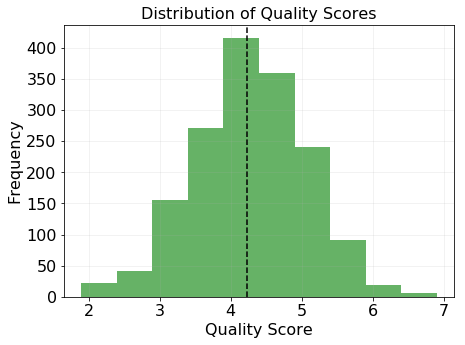

In [37]:
plt.figure(figsize=(7,5))
plt.hist(df1['EitherScore'], alpha=0.6, color='green')
plt.axvline((df1['EitherScore'].mean()), color = 'black', linestyle='--')
plt.title("Distribution of Quality Scores", fontsize=16)
plt.xlabel("Quality Score", fontsize=16)
plt.ylabel("Frequency", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(alpha=0.2)

**Fig 1. After cleaninng and merging, 1622 quality score records remained. The distribution of those quality scores appears to be normally distributed. **

In [38]:
print("Pre-K Enrollment:", int(df1['Enrollment'].sum()))

Pre-K Enrollment: 62109


In [39]:
#Enrollment sums per borough

df1.groupby('Borough')['Enrollment'].sum().sort_values(ascending=False)

Borough
K    20274.0
Q    18083.0
X    12692.0
M     7616.0
R     3444.0
Name: Enrollment, dtype: float64

In [40]:
# Average scores by borough Queens has the highest score on average, while the Bronx has the lowest score. 

df1.groupby('Borough')['EitherScore'].mean().sort_values(ascending=False)

Borough
Q    4.553020
R    4.345000
K    4.206962
M    3.985248
X    3.983501
Name: EitherScore, dtype: float64

In [41]:
print("Pre-K Sites per Borough")
print(df1['Borough'].value_counts())
print("K = Brooklyn", "\n"
     "Q = Queens", "\n"
     "X = Bronx", "\n"
     "M = Manhattan", "\n"
     "R = Staten Island")

Pre-K Sites per Borough
K    541
Q    447
X    299
M    235
R    100
Name: Borough, dtype: int64
K = Brooklyn 
Q = Queens 
X = Bronx 
M = Manhattan 
R = Staten Island


## Part Three: Mapping

In [42]:
# Not Python3 compatible

crs = {'init': 'epsg:4326'}

school_loc = df1[['Longitude', 'Latitude', 'Census Tract', 'Seats',
                  'ATS_CODE', 'EitherScore', 'Enrollment', 'Borough']]
school_loc = gpd.GeoDataFrame(school_loc, crs=crs)
school_loc['lonlat'] = zip(school_loc.Longitude, school_loc.Latitude)
school_loc['geometry'] = school_loc[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
school_loc.head()

,Longitude,Latitude,Census Tract,Seats,ATS_CODE,EitherScore,Enrollment,Borough,lonlat,geometry
0,-73.955338,40.682663,227,90,K003,3.9,67.0,K,"(-73.955338, 40.682663)",POINT (-73.955338 40.682663)
1,-73.922463,40.685695,377,36,K005,3.4,19.0,K,"(-73.922463, 40.685695)",POINT (-73.92246299999999 40.685695)
2,-73.956716,40.715351,519,28,K017,2.3,22.0,K,"(-73.956716, 40.715351)",POINT (-73.956716 40.715351)
3,-73.971376,40.690765,183,54,K020,4.5,54.0,K,"(-73.971376, 40.690765)",POINT (-73.97137600000001 40.690765)
4,-73.926597,40.680727,381,54,K021,3.5,46.0,K,"(-73.926597, 40.680727)",POINT (-73.926597 40.680727)


In [43]:
schoolshp = schoolshp.to_crs({'init': 'epsg:4326'})
schoolshp.crs

{'init': 'epsg:4326'}

In [44]:
# Merging school locations and school shapefile 

schools2 = gpd.sjoin(school_loc, schoolshp, how='left', op='within')
print(schools2.shape)
schools2.head()

(1622, 28)


,Longitude,Latitude,Census Tract,Seats,ATS_CODE_left,EitherScore,Enrollment,Borough,lonlat,geometry,...,GEO_DISTRI,ADMIN_DIST,ADDRESS,STATE_CODE,ZIP,PRINCIPAL,PRIN_PH,FAX,GRADES,City
0,-73.955338,40.682663,227,90,K003,3.9,67.0,K,"(-73.955338, 40.682663)",POINT (-73.955338 40.682663),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-73.922463,40.685695,377,36,K005,3.4,19.0,K,"(-73.922463, 40.685695)",POINT (-73.92246299999999 40.685695),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-73.956716,40.715351,519,28,K017,2.3,22.0,K,"(-73.956716, 40.715351)",POINT (-73.956716 40.715351),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-73.971376,40.690765,183,54,K020,4.5,54.0,K,"(-73.971376, 40.690765)",POINT (-73.97137600000001 40.690765),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-73.926597,40.680727,381,54,K021,3.5,46.0,K,"(-73.926597, 40.680727)",POINT (-73.926597 40.680727),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
ctshp = ctshp.to_crs({'init': 'epsg:4236'})
ctshp.crs

{'init': 'epsg:4236'}

In [46]:
schools2.drop(['index_right'], axis=1, inplace=True)
schools3 = gpd.sjoin(schools2, ctshp, how='left', op='within')
print(schools3.shape)
schools3.head()

(1622, 39)


,Longitude,Latitude,Census Tract,Seats,ATS_CODE_left,EitherScore,Enrollment,Borough,lonlat,geometry,...,BoroCode,BoroName,CT2010,BoroCT2010,CDEligibil,NTACode,NTAName,PUMA,Shape_Leng,Shape_Area
0,-73.955338,40.682663,227,90,K003,3.9,67.0,K,"(-73.955338, 40.682663)",POINT (-73.955338 40.682663),...,3,Brooklyn,020500,3020500,I,BK64,Prospect Heights,4006,5441.543624,1.718970e+06
1,-73.922463,40.685695,377,36,K005,3.4,19.0,K,"(-73.922463, 40.685695)",POINT (-73.92246299999999 40.685695),...,3,Brooklyn,029700,3029700,I,BK61,Crown Heights North,4006,5858.602672,2.212768e+06
2,-73.956716,40.715351,519,28,K017,2.3,22.0,K,"(-73.956716, 40.715351)",POINT (-73.956716 40.715351),...,3,Brooklyn,054900,3054900,E,BK73,North Side-South Side,4001,6846.966625,2.097683e+06
3,-73.971376,40.690765,183,54,K020,4.5,54.0,K,"(-73.971376, 40.690765)",POINT (-73.97137600000001 40.690765),...,3,Brooklyn,003900,3003900,I,BK38,DUMBO-Vinegar Hill-Downtown Brooklyn-Boerum Hill,4004,5101.749748,1.681241e+06
4,-73.926597,40.680727,381,54,K021,3.5,46.0,K,"(-73.926597, 40.680727)",POINT (-73.926597 40.680727),...,3,Brooklyn,030900,3030900,E,BK61,Crown Heights North,4006,5470.581443,1.587377e+06


In [47]:
schools3.columns

Index([     u'Longitude',       u'Latitude',   u'Census Tract',
                u'Seats',  u'ATS_CODE_left',    u'EitherScore',
           u'Enrollment',        u'Borough',         u'lonlat',
             u'geometry', u'ATS_CODE_right',           u'BORO',
              u'BORONUM',       u'LOC_CODE',     u'SCHOOLNAME',
             u'SCH_TYPE',     u'MANAGED_BY',     u'GEO_DISTRI',
           u'ADMIN_DIST',        u'ADDRESS',     u'STATE_CODE',
                  u'ZIP',      u'PRINCIPAL',        u'PRIN_PH',
                  u'FAX',         u'GRADES',           u'City',
          u'index_right',        u'CTLabel',       u'BoroCode',
             u'BoroName',         u'CT2010',     u'BoroCT2010',
           u'CDEligibil',        u'NTACode',        u'NTAName',
                 u'PUMA',     u'Shape_Leng',     u'Shape_Area'],
      dtype='object')

In [48]:
#Checking the new schools3 df is consistent with the original cleaned df

print("Pre-K Enrollment:", int(df1['Enrollment'].sum()))
print("Pre-K Enrollment:", int(schools3['Enrollment'].sum()))

Pre-K Enrollment: 62109
Pre-K Enrollment: 62109


In [49]:
ctshp['CT2010'] = ctshp['CT2010'].astype(int)

allmerge = ctshp.merge(censusdf, left_on='CT2010', right_on='tract')
under5map = ctshp.merge(censusdf, left_on='CT2010', right_on='tract')

In [50]:
allmerge = allmerge.drop_duplicates('CT2010')
allmerge.shape

(1308, 17)

In [51]:
allmerge.columns

Index([       u'CTLabel',       u'BoroCode',       u'BoroName',
               u'CT2010',     u'BoroCT2010',     u'CDEligibil',
              u'NTACode',        u'NTAName',           u'PUMA',
           u'Shape_Leng',     u'Shape_Area',       u'geometry',
                u'tract',  u'HS_Above_Perc',    u'Under5_Perc',
       u'S2001_C01_002E', u'S0101_C01_002E'],
      dtype='object')

In [52]:
schools3.columns

Index([     u'Longitude',       u'Latitude',   u'Census Tract',
                u'Seats',  u'ATS_CODE_left',    u'EitherScore',
           u'Enrollment',        u'Borough',         u'lonlat',
             u'geometry', u'ATS_CODE_right',           u'BORO',
              u'BORONUM',       u'LOC_CODE',     u'SCHOOLNAME',
             u'SCH_TYPE',     u'MANAGED_BY',     u'GEO_DISTRI',
           u'ADMIN_DIST',        u'ADDRESS',     u'STATE_CODE',
                  u'ZIP',      u'PRINCIPAL',        u'PRIN_PH',
                  u'FAX',         u'GRADES',           u'City',
          u'index_right',        u'CTLabel',       u'BoroCode',
             u'BoroName',         u'CT2010',     u'BoroCT2010',
           u'CDEligibil',        u'NTACode',        u'NTAName',
                 u'PUMA',     u'Shape_Leng',     u'Shape_Area'],
      dtype='object')

In [53]:
allmerged2 = allmerge.merge(schools3, left_on='BoroCT2010', right_on='BoroCT2010')

#### Making a choropleth

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


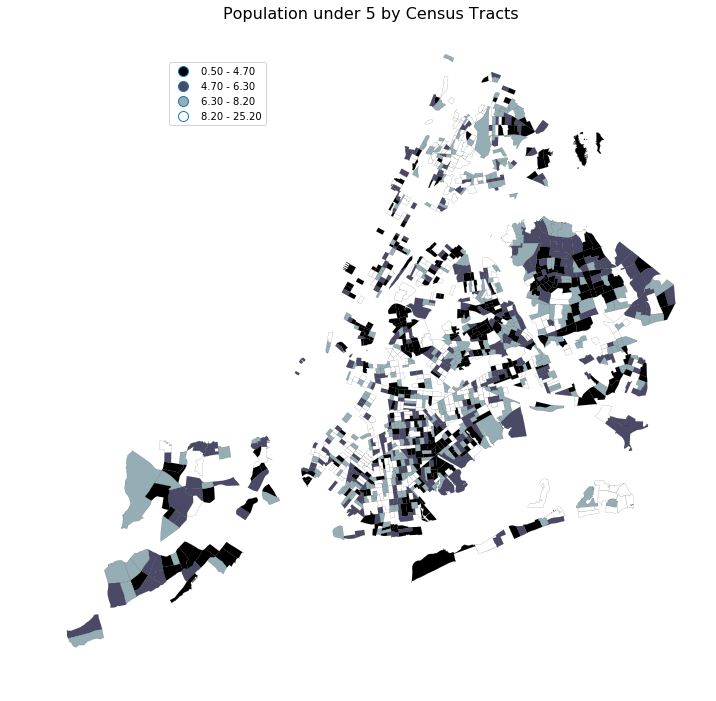

In [55]:
ax = pl.figure(figsize=(12,12)).add_subplot(111)
cp.choroplethNYC(allmerge, column='S0101_C01_002E', cmap='bone', scheme='quantiles', k=4,
                 edgecolor='k', lw=0.1, ax=ax)
plt.title("Population under 5 by Census Tracts", fontsize=16)

**Fig 2: Number of children under 5 per census tract.**

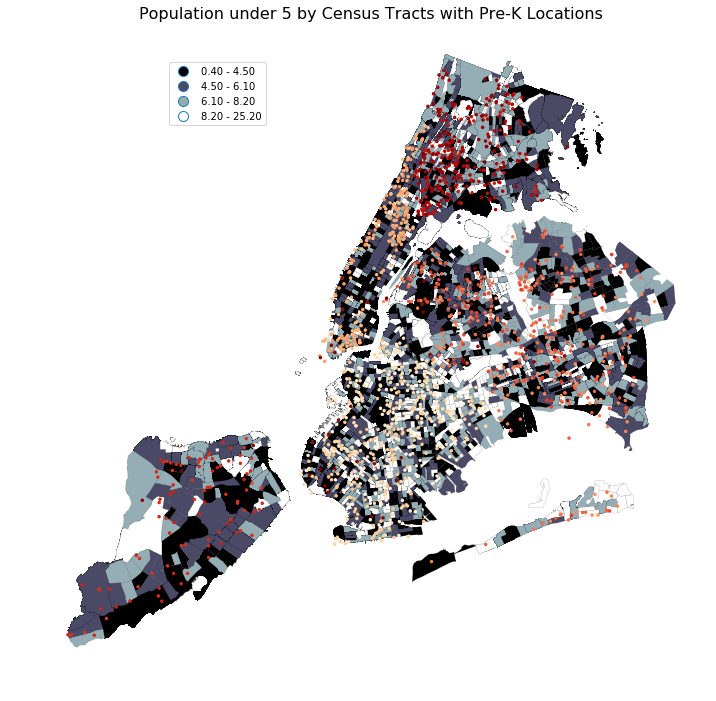

In [56]:
ax = pl.figure(figsize=(12,12)).add_subplot(111)
cp.choroplethNYC(under5map, column='S0101_C01_002E', cmap='bone', 
                 scheme='quantiles', k=4,
                 edgecolor='k', lw=0.1, ax=ax)
schools3.plot(marker='o', c='EitherScore', markersize=6, cmap='OrRd', ax=ax)
#schools3.plot(marker='o', c='EitherScore', markersize=5, cmap='OrRd', 
              #ax=ax, legend=True, scheme='equal_interval', k=3)
plt.title("Population under 5 by Census Tracts with Pre-K Locations", fontsize=16)

**Fig 3: A visual assessment of pre-k location quality mapped over population under 5 does not show any immediate trends.**

#### Descriptive states for best 100 and worst 100 schools 

In [57]:
#schools3.sort_values(by='EitherScore', ascending=False).head(10)
top100 = schools3.nlargest(100, 'EitherScore')
top100.head()

,Longitude,Latitude,Census Tract,Seats,ATS_CODE_left,EitherScore,Enrollment,Borough,lonlat,geometry,...,BoroCode,BoroName,CT2010,BoroCT2010,CDEligibil,NTACode,NTAName,PUMA,Shape_Leng,Shape_Area
252,-73.913702,40.696805,435,20,GY,6.900000,20.0,K,"(-73.913702, 40.696805)",POINT (-73.913702 40.696805),...,3,Brooklyn,039500,3039500,E,BK78,Bushwick South,4002,5825.771144,1.718426e+06
769,-73.795304,40.594538,964,54,Q042,6.466667,47.0,Q,"(-73.795304, 40.594538)",POINT (-73.795304 40.594538),...,4,Queens,094202,4094202,E,QN12,Hammels-Arverne-Edgemere,4114,21766.241008,7.609021e+06
1054,-73.806969,40.709672,230,30,WW,6.466667,31.0,Q,"(-73.806969, 40.709672)",POINT (-73.806969 40.709672),...,4,Queens,021400,4021400,E,QN35,Briarwood-Jamaica Hills,4106,8483.171196,4.031658e+06
1061,-73.767379,40.666171,306,36,XI,6.466667,25.0,Q,"(-73.767379, 40.666171)",POINT (-73.76737900000001 40.66617100000001),...,4,Queens,030600,4030600,I,QN03,Springfield Gardens South-Brookville,4105,22071.317453,1.440561e+07
364,-73.966544,40.634005,526,18,RH,6.433333,18.0,K,"(-73.966544, 40.634005)",POINT (-73.966544 40.634005),...,3,Brooklyn,048000,3048000,E,BK42,Flatbush,4015,5432.248963,1.643798e+06


In [58]:
#schools3.sort_values(by='EitherScore', ascending=True).head(20)
bottom100 = schools3.nsmallest(100, 'EitherScore')
bottom100.head()

,Longitude,Latitude,Census Tract,Seats,ATS_CODE_left,EitherScore,Enrollment,Borough,lonlat,geometry,...,BoroCode,BoroName,CT2010,BoroCT2010,CDEligibil,NTACode,NTAName,PUMA,Shape_Leng,Shape_Area
72,-73.940002,40.708723,485,46,K196,1.9,35.0,K,"(-73.940002, 40.708723)",POINT (-73.94000200000001 40.708723),...,3,Brooklyn,050900,3050900,E,BK72,Williamsburg,4001,5020.253950,1.526103e+06
119,-73.942639,40.674794,341,48,K289,1.9,31.0,K,"(-73.942639, 40.674794)",POINT (-73.942639 40.674794),...,3,Brooklyn,031702,3031702,E,BK61,Crown Heights North,4006,5031.463063,1.500337e+06
463,-73.981489,40.594458,402,18,JM,1.9,18.0,K,"(-73.981489, 40.594458)",POINT (-73.981489 40.594458),...,3,Brooklyn,031400,3031400,E,BK26,Gravesend,4018,23907.868361,8.954916e+06
768,-73.790675,40.694125,260,36,Q040,1.9,33.0,Q,"(-73.790675, 40.694125)",POINT (-73.79067499999999 40.694125),...,4,Queens,019600,4019600,E,QN01,South Jamaica,4112,7476.959905,2.402964e+06
87,-73.969964,40.590564,37401,102,K216,2.0,92.0,K,"(-73.969964, 40.590564)",POINT (-73.969964 40.590564),...,3,Brooklyn,030800,3030800,E,BK26,Gravesend,4018,12485.092654,7.193620e+06


In [59]:
top100['Borough'].value_counts()

Q    46
K    33
M     8
X     8
R     5
Name: Borough, dtype: int64

In [60]:
bottom100['Borough'].value_counts()

K    40
X    28
M    23
Q     7
R     2
Name: Borough, dtype: int64

Looking at the number of top 100 and bottom 100 schools in each borough does not provide a lot of information. For instance, you can see that Brooklyn has both a lot of good and bad schools.

In [61]:
(top100.groupby('Borough')['Seats'].count() / schools3.groupby('Borough')['Seats'].count()) * 100

Borough
K     6.099815
M     3.404255
Q    10.290828
R     5.000000
X     2.675585
Name: Seats, dtype: float64

In [62]:
(bottom100.groupby('Borough')['Seats'].count() / schools3.groupby('Borough')['Seats'].count()) * 100

Borough
K    7.393715
M    9.787234
Q    1.565996
R    2.000000
X    9.364548
Name: Seats, dtype: float64

By normalzing by the total number of schools in the borough, you can get a better idea of what percentage of schools per borough are in the top 100 or bottom 100. Some notable takeaways: 
- Only 1.5% of Queens schools are in the bottom 100, and 10% are in the top 100 
- Only 2% of Bronx schools in the top 100, and 9.3% are in the bottom 100 

## Part 4: Regression

In [63]:
allmerged2.columns

Index([     u'CTLabel_x',     u'BoroCode_x',     u'BoroName_x',
             u'CT2010_x',     u'BoroCT2010',   u'CDEligibil_x',
            u'NTACode_x',      u'NTAName_x',         u'PUMA_x',
         u'Shape_Leng_x',   u'Shape_Area_x',     u'geometry_x',
                u'tract',  u'HS_Above_Perc',    u'Under5_Perc',
       u'S2001_C01_002E', u'S0101_C01_002E',      u'Longitude',
             u'Latitude',   u'Census Tract',          u'Seats',
        u'ATS_CODE_left',    u'EitherScore',     u'Enrollment',
              u'Borough',         u'lonlat',     u'geometry_y',
       u'ATS_CODE_right',           u'BORO',        u'BORONUM',
             u'LOC_CODE',     u'SCHOOLNAME',       u'SCH_TYPE',
           u'MANAGED_BY',     u'GEO_DISTRI',     u'ADMIN_DIST',
              u'ADDRESS',     u'STATE_CODE',            u'ZIP',
            u'PRINCIPAL',        u'PRIN_PH',            u'FAX',
               u'GRADES',           u'City',    u'index_right',
            u'CTLabel_y',     u'BoroCode

In [64]:
allmerge = allmerge.drop_duplicates('CT2010')
allmerge.shape

(1308, 17)

In [65]:
allmerged2.shape

(820, 55)

In [66]:
lm1 = smf.ols('EitherScore ~ S2001_C01_002E + HS_Above_Perc + Under5_Perc', data=allmerged2).fit()
lm1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            EitherScore   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.3711
Date:                Thu, 14 Dec 2017   Prob (F-statistic):              0.774
Time:                        21:55:56   Log-Likelihood:                -942.61
No. Observations:                 815   AIC:                             1893.
Df Residuals:                     811   BIC:                             1912.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
Intercept          4.0806      0.214     19.052      0.000         3.660     4.501
S2001_C01_002E -3.776e-07   2.27e-06     -0.166      0.868     -4.84e-06  4.09e-06
HS_Above_Perc      0.2640      0.283      0.932      0.352        -0.292     0.820
Under5_Perc       -0.6544      3.503     -0.187      0.852        -7.530     6.221
==============================================================================
Omnibus:                        3.826   Durbin-Watson:                   1.795
Prob(Omnibus):                  0.148   Jarque-Bera (JB):                3.892
Skew:                          -0.164   Prob(JB):                        0.143
Kurtosis:                       2.918   Cond. No.                     4.91e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.91e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [67]:
allmerged2['EitherScore'].mean()

4.291544715447154

In [68]:
allmerged2.head()

,CTLabel_x,BoroCode_x,BoroName_x,CT2010_x,BoroCT2010,CDEligibil_x,NTACode_x,NTAName_x,PUMA_x,Shape_Leng_x,...,CTLabel_y,BoroCode_y,BoroName_y,CT2010_y,CDEligibil_y,NTACode_y,NTAName_y,PUMA_y,Shape_Leng_y,Shape_Area_y
0,100,1,Manhattan,10000,1010000,I,MN19,Turtle Bay-East Midtown,3808,5692.168737,...,100,1,Manhattan,010000,I,MN19,Turtle Bay-East Midtown,3808,5692.168737,1.860938e+06
1,102,1,Manhattan,10200,1010200,I,MN17,Midtown-Midtown South,3807,5687.802439,...,102,1,Manhattan,010200,I,MN17,Midtown-Midtown South,3807,5687.802439,1.860993e+06
2,114.02,1,Manhattan,11402,1011402,I,MN40,Upper East Side-Carnegie Hill,3805,4125.256029,...,114.02,1,Manhattan,011402,I,MN40,Upper East Side-Carnegie Hill,3805,4125.256029,1.063547e+06
3,184,1,Manhattan,18400,1018400,E,MN34,East Harlem North,3804,5771.874098,...,184,1,Manhattan,018400,E,MN34,East Harlem North,3804,5771.874098,1.903568e+06
4,184,1,Manhattan,18400,1018400,E,MN34,East Harlem North,3804,5771.874098,...,184,1,Manhattan,018400,E,MN34,East Harlem North,3804,5771.874098,1.903568e+06


In [69]:
lm2 = smf.ols('EitherScore ~ S2001_C01_002E', data=allmerged2).fit()
lm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            EitherScore   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                   0.09837
Date:                Thu, 14 Dec 2017   Prob (F-statistic):              0.754
Time:                        21:55:58   Log-Likelihood:                -949.99
No. Observations:                 820   AIC:                             1904.
Df Residuals:                     818   BIC:                             1913.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
Intercept          4.2713      0.070     61.016      0.000         4.134     4.409
S2001_C01_002E  5.796e-07   1.85e-06      0.314      0.754     -3.05e-06  4.21e-06
==============================================================================
Omnibus:                        3.443   Durbin-Watson:                   1.782
Prob(Omnibus):                  0.179   Jarque-Bera (JB):                3.517
Skew:                          -0.152   Prob(JB):                        0.172
Kurtosis:                       2.900   Cond. No.                     9.84e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.84e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [70]:
lm2 = smf.ols('EitherScore ~ HS_Above_Perc', data=allmerged2).fit()
lm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            EitherScore   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.053
Date:                Thu, 14 Dec 2017   Prob (F-statistic):              0.305
Time:                        21:55:59   Log-Likelihood:                -942.64
No. Observations:                 815   AIC:                             1889.
Df Residuals:                     813   BIC:                             1899.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept         4.0896      0.204     20.055      0.000         3.689     4.490
HS_Above_Perc     0.2368      0.231      1.026      0.305        -0.216     0.690
==============================================================================
Omnibus:                        3.796   Durbin-Watson:                   1.795
Prob(Omnibus):                  0.150   Jarque-Bera (JB):                3.862
Skew:                          -0.164   Prob(JB):                        0.145
Kurtosis:                       2.920   Cond. No.                         15.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""